In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv('https://www.ispdados.rj.gov.br/Arquivos/UppEvolucaoMensalDeTitulos.csv', sep = ';', encoding= 'latin 1')

=== Estatísticas Descritivas ===
                      count         mean         std    min     25%    50%  \
apreensao_drogas       18.0  1072.555556  837.394785  117.0  439.75  898.0   
recuperacao_veiculos   18.0   635.111111  327.848044  147.0  457.25  587.5   
armas_apreendidas      18.0   294.444444  170.847790   65.0  167.00  292.5   
cump_mandado_prisao    18.0   214.666667  105.554001   45.0  110.25  209.5   
ocorr_flagrante        18.0   862.111111  479.773340  239.0  520.50  754.5   

                          75%     max  mediana  dist_media_mediana      Q1  \
apreensao_drogas      1382.25  2744.0    898.0          174.555556  439.75   
recuperacao_veiculos   707.75  1426.0    587.5           47.611111  457.25   
armas_apreendidas      379.50   757.0    292.5            1.944444  167.00   
cump_mandado_prisao    313.50   385.0    209.5            5.166667  110.25   
ocorr_flagrante       1163.75  1783.0    754.5          107.611111  520.50   

                         Q2  

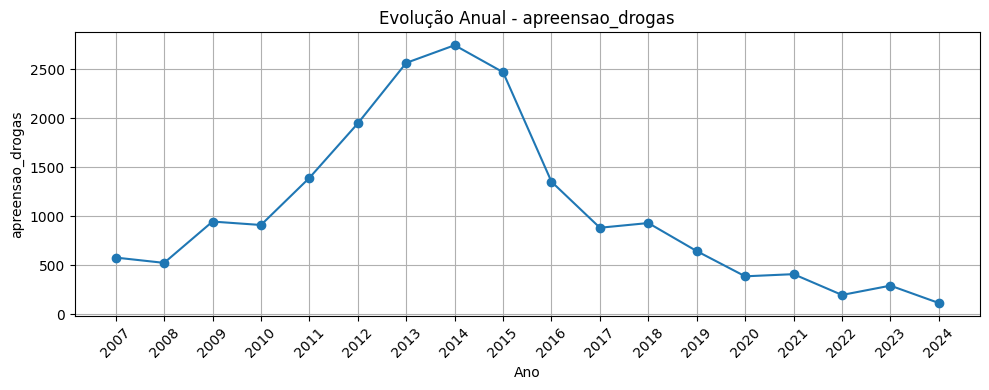

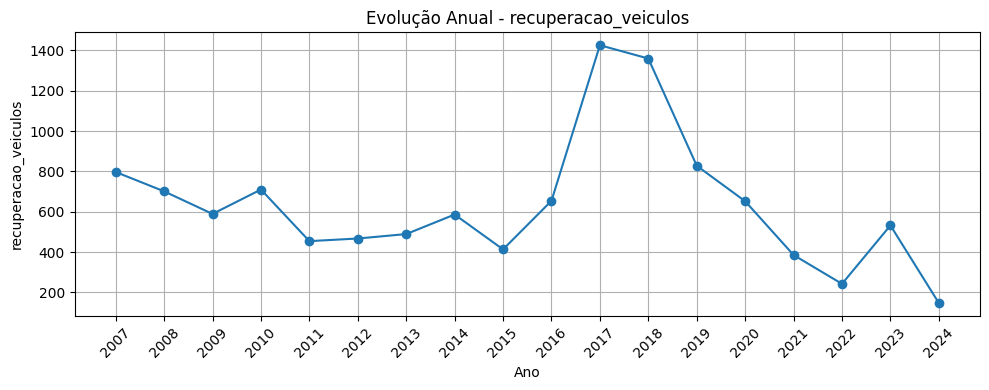

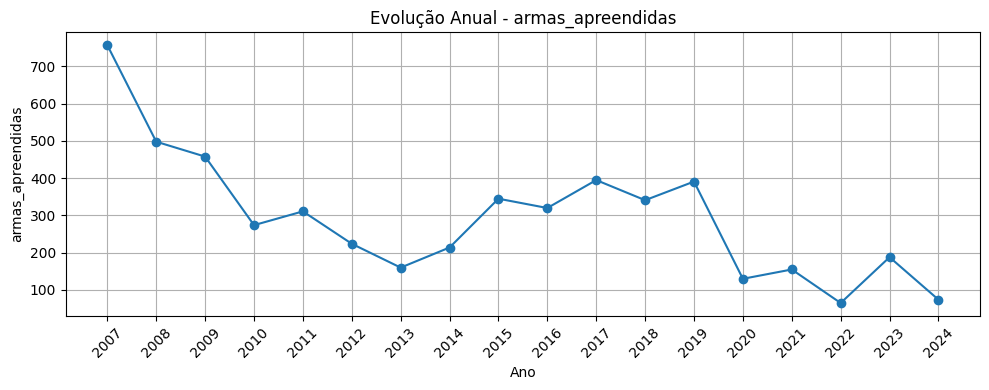

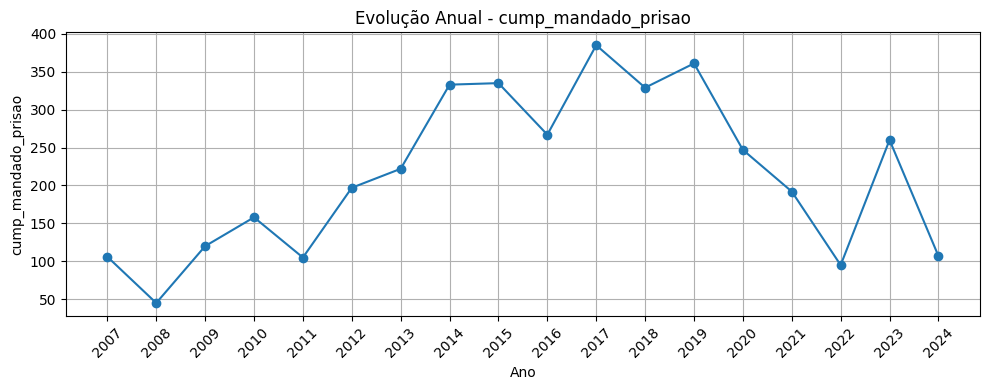

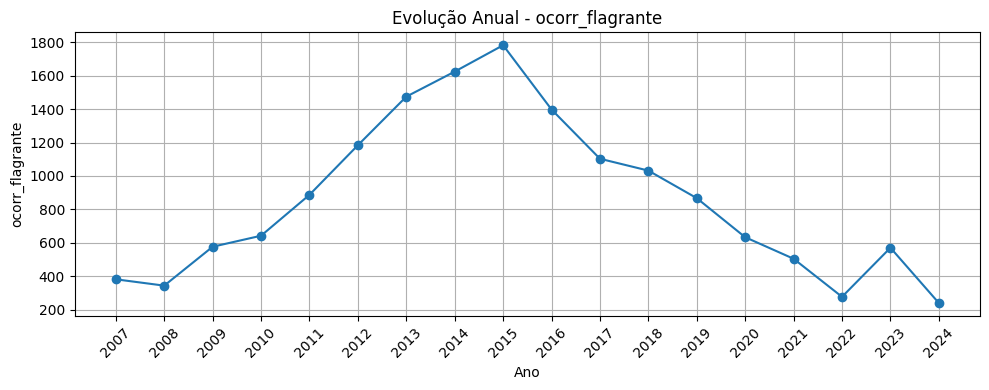

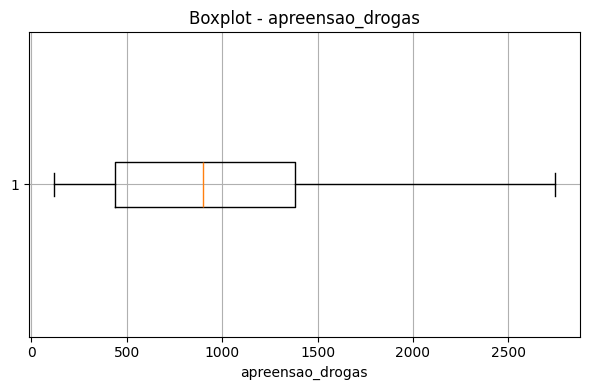

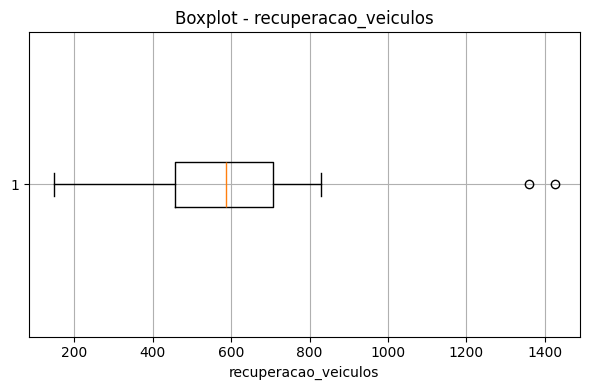

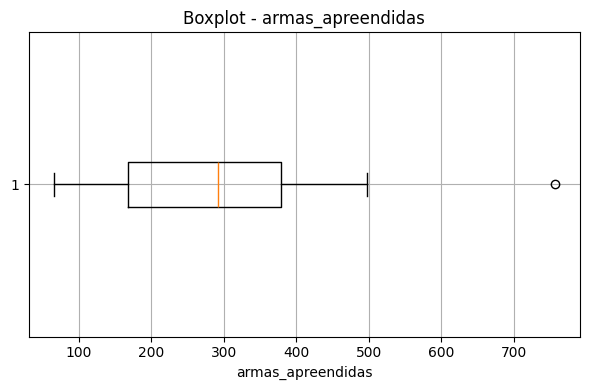

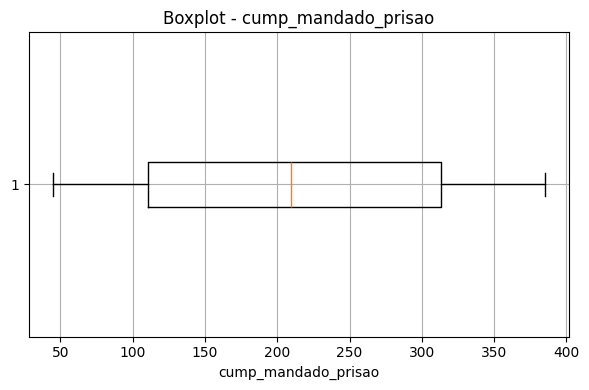

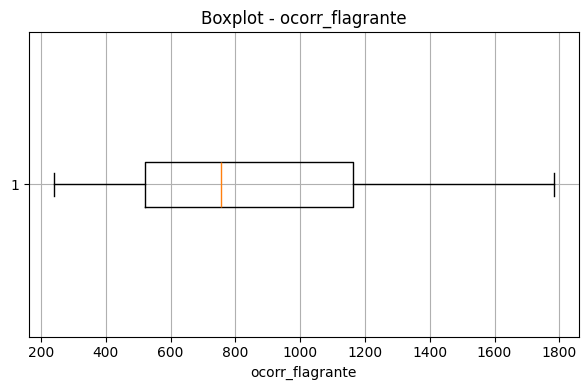


 Anos com Outliers 
      apreensao_drogas  recuperacao_veiculos  armas_apreendidas  \
ano                                                               
2007               580                   797                757   
2017               884                  1426                395   
2018               932                  1360                341   

      cump_mandado_prisao  ocorr_flagrante  
ano                                         
2007                  106              381  
2017                  385             1103  
2018                  329             1032  

 Anos sem Outliers 
      apreensao_drogas  recuperacao_veiculos  armas_apreendidas  \
ano                                                               
2008               526                   701                498   
2009               947                   589                458   
2010               912                   710                274   
2011              1392                   454                31

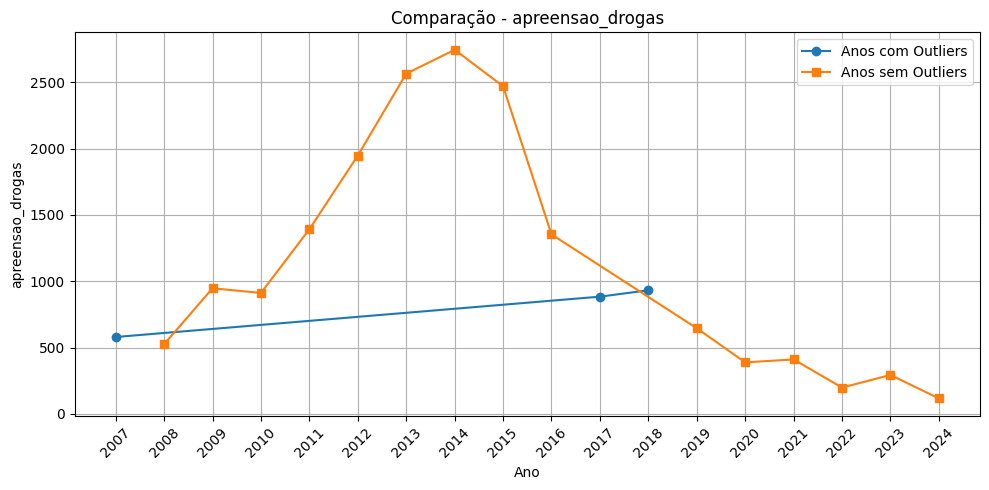

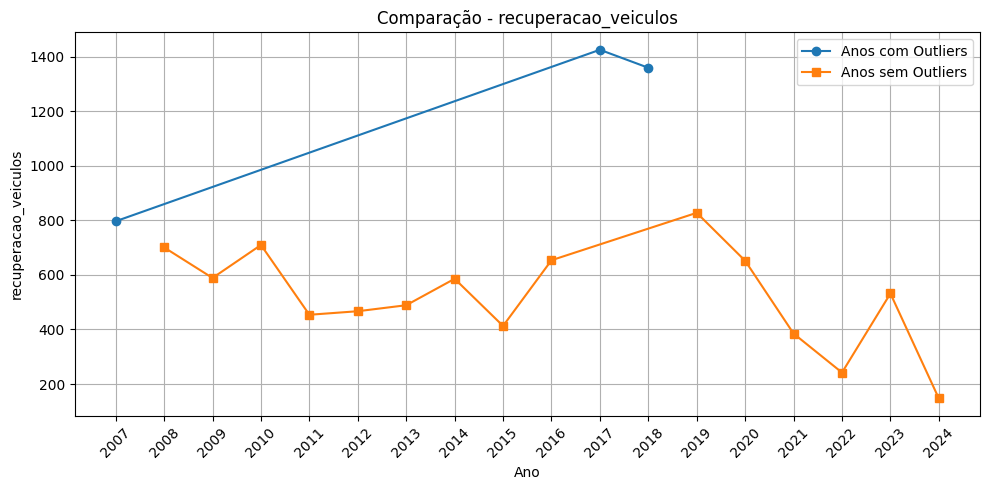

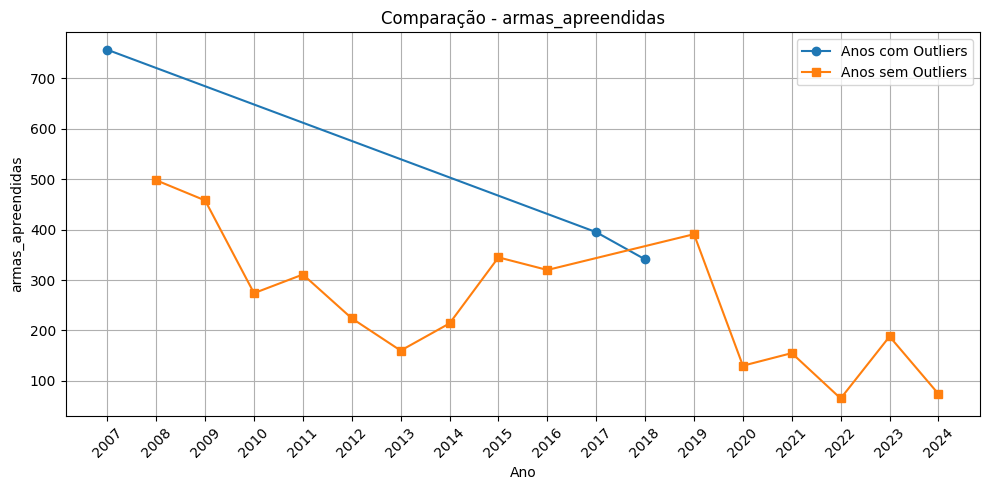

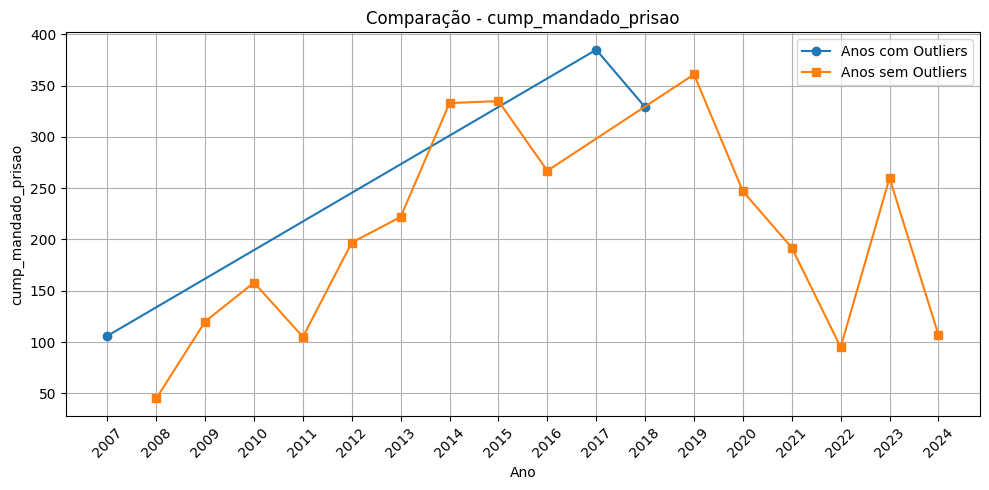

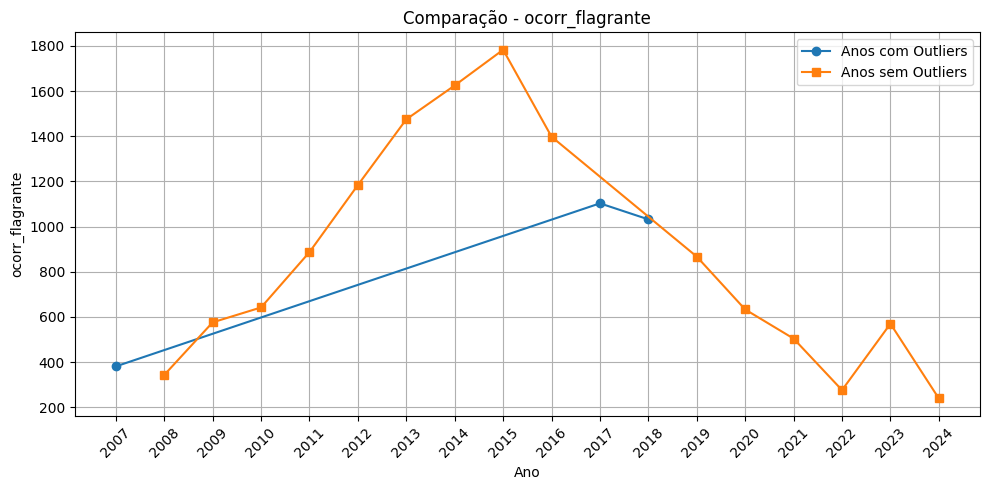

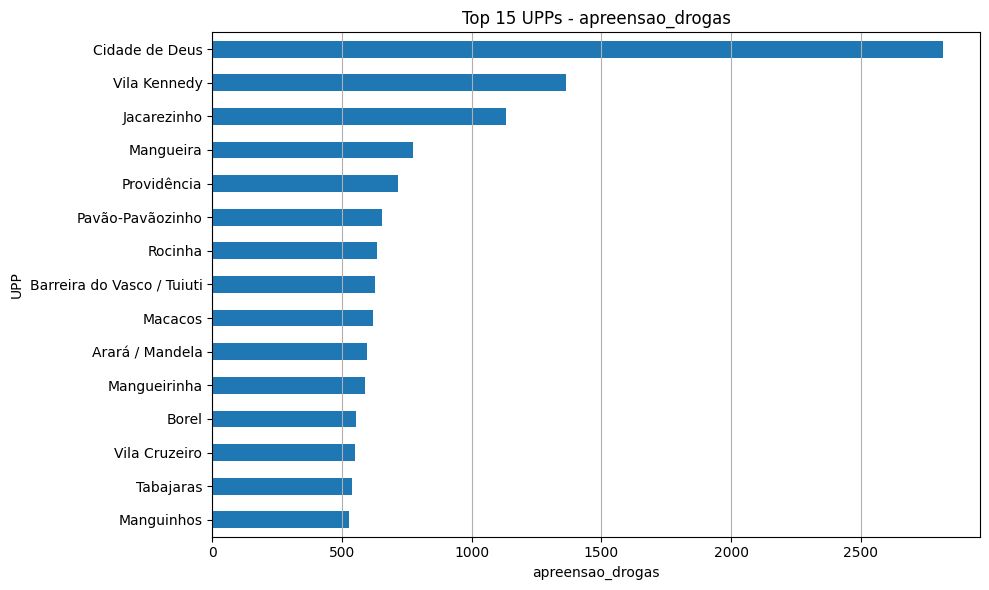

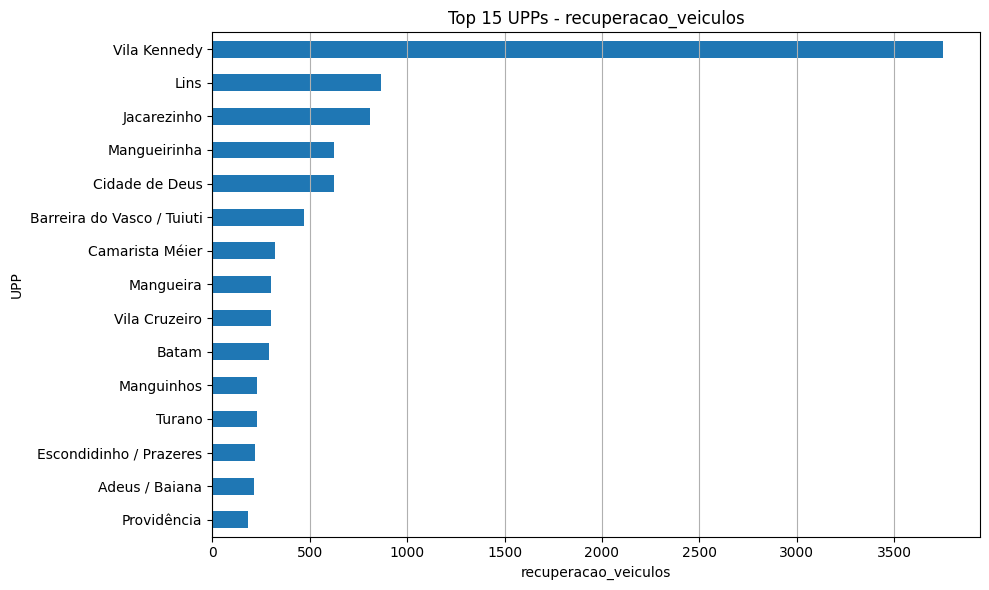

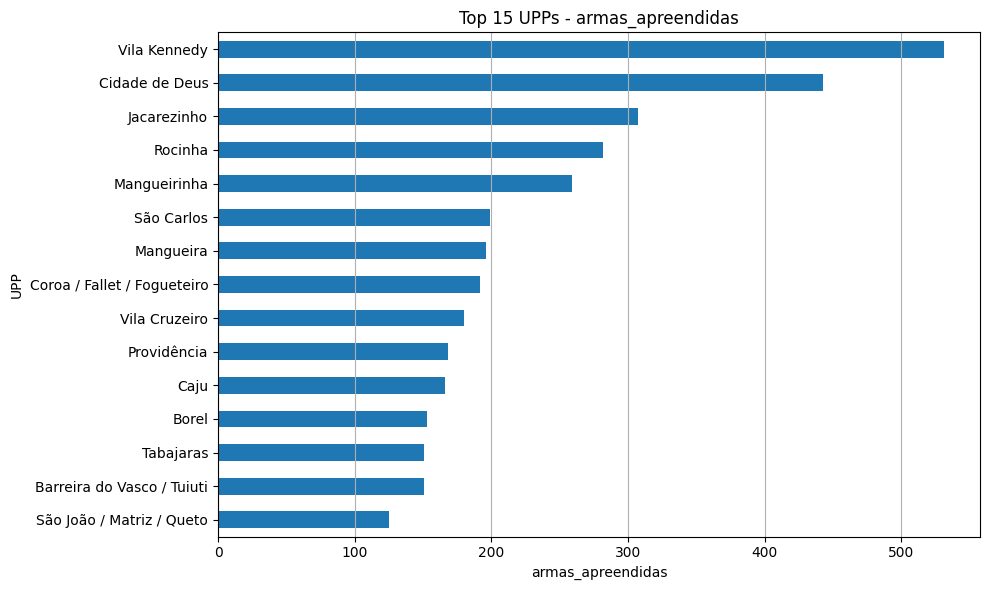

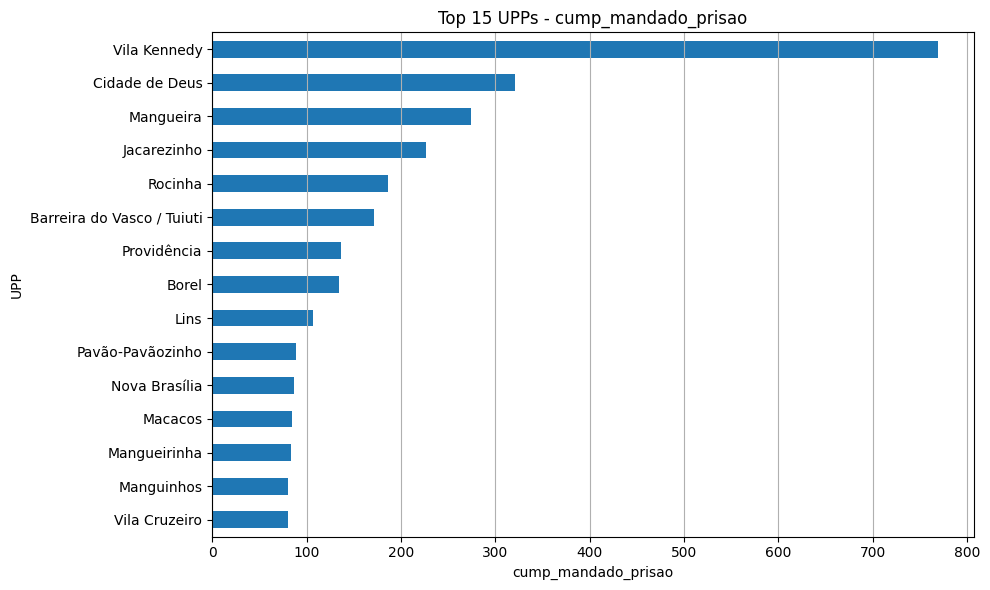

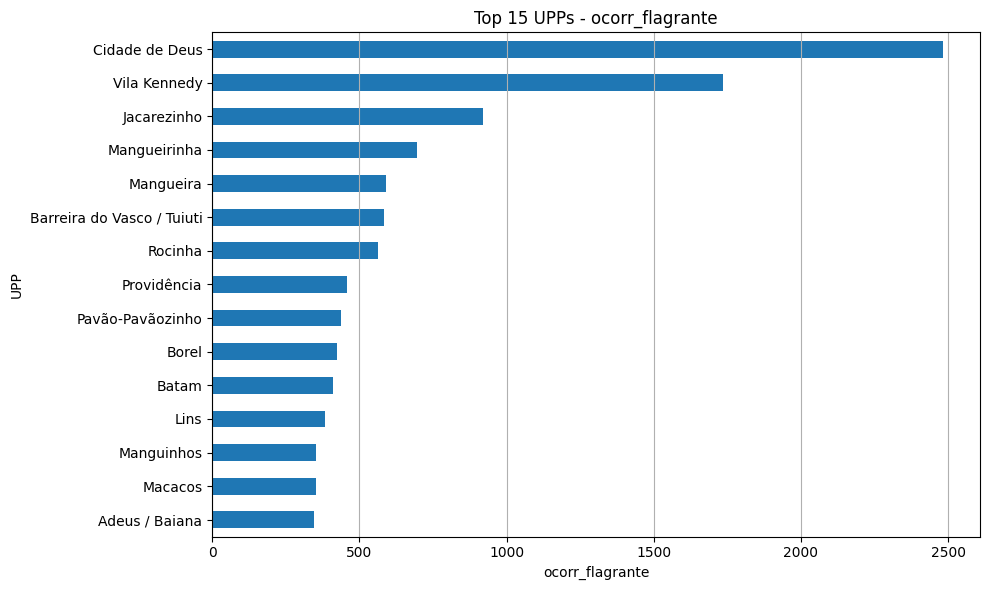

In [18]:

variaveis_interesse = [
    "apreensao_drogas",
    "recuperacao_veiculos",
    "armas_apreendidas",
    "cump_mandado_prisao",
    "ocorr_flagrante"
]

# 4. Agrupar por ano
df_ano = df.groupby('ano')[variaveis_interesse].sum()

# 5. Estatísticas descritivas
stats = df_ano.describe().T
stats['mediana'] = df_ano.median()
stats['dist_media_mediana'] = abs(stats['mean'] - stats['mediana'])
stats['Q1'] = df_ano.quantile(0.25)
stats['Q2'] = df_ano.quantile(0.50)
stats['Q3'] = df_ano.quantile(0.75)
print("=== Estatísticas Descritivas ===")
print(stats)

# 6. Gráficos de linha com todos os anos visíveis
for var in variaveis_interesse:
    plt.figure(figsize=(10, 4))
    plt.plot(df_ano.index, df_ano[var], marker='o')
    plt.title(f"Evolução Anual - {var}")
    plt.xlabel("Ano")
    plt.ylabel(var)
    plt.xticks(df_ano.index, rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 7. Boxplots para visualização de outliers
for var in variaveis_interesse:
    plt.figure(figsize=(6, 4))
    plt.boxplot(df_ano[var], vert=False)
    plt.title(f"Boxplot - {var}")
    plt.xlabel(var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 8. Função para identificar outliers
def identificar_outliers(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    limite_inferior = q1 - 1.5 * iqr
    limite_superior = q3 + 1.5 * iqr
    return series[(series < limite_inferior) | (series > limite_superior)]

# 9. Identificação de anos com outliers
outliers_dict = {
    var: identificar_outliers(df_ano[var]).index.tolist()
    for var in variaveis_interesse
}
outliers_df = pd.DataFrame.from_dict(outliers_dict, orient='index').transpose()
anos_com_outliers = [ano for ano in outliers_df.values.flatten() if pd.notna(ano)]
anos_com_outliers = sorted(set(int(ano) for ano in anos_com_outliers))
anos_sem_outliers = sorted(set(df_ano.index) - set(anos_com_outliers))

# 10. Separar os dados
df_outliers = df_ano.loc[anos_com_outliers]
df_normais = df_ano.loc[anos_sem_outliers]

print("\n Anos com Outliers ")
print(df_outliers)

print("\n Anos sem Outliers ")
print(df_normais)

# 11. Comparação gráfica entre anos com e sem outliers
for var in variaveis_interesse:
    plt.figure(figsize=(10, 5))
    plt.plot(df_outliers.index, df_outliers[var], marker='o', label='Anos com Outliers')
    plt.plot(df_normais.index, df_normais[var], marker='s', label='Anos sem Outliers')
    plt.title(f'Comparação - {var}')
    plt.xlabel('Ano')
    plt.ylabel(var)
    plt.xticks(sorted(df_ano.index), rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 12. Top 15 UPPs por variável
for var in variaveis_interesse:
    top_upps = df.groupby('upp')[var].sum().sort_values(ascending=False).head(15)
    plt.figure(figsize=(10, 6))
    top_upps.plot(kind='barh')
    plt.title(f'Top 15 UPPs - {var}')
    plt.xlabel(var)
    plt.ylabel('UPP')
    plt.gca().invert_yaxis()
    plt.grid(True, axis='x')
    plt.tight_layout()
    plt.show()


In [19]:
# Adicionar coluna indicando se o ano é outlier para cada variável
outlier_flags = pd.DataFrame(index=df_ano.index)

for var in variaveis_interesse:
    outlier_flags[f"{var}_outlier"] = df_ano.index.isin(outliers_dict[var])

# Consolidar estatísticas
stats_full = stats.copy()
stats_full['variavel'] = stats_full.index

# Transformar estatísticas em formato "longo" para juntar com info de outliers
stats_melted = stats_full.melt(id_vars='variavel', var_name='estatistica', value_name='valor')

# Criar tabela com dados por ano e variáveis, incluindo flag de outlier
dados_long = df_ano.reset_index().melt(id_vars='ano', var_name='variavel', value_name='ocorrencias')
dados_long['outlier'] = dados_long.apply(lambda row: row['ano'] in outliers_dict[row['variavel']], axis=1)

# Unir estatísticas com dados por ano
resultado_final = dados_long.merge(stats_melted, on='variavel', how='left')

# Salvar tudo em um único CSV
resultado_final.to_csv("analise_completa_atividade_policial.csv", encoding="utf-8-sig", index=False)

print("Arquivo único 'analise_completa_atividade_policial.csv' gerado com sucesso!")


Arquivo único 'analise_completa_atividade_policial.csv' gerado com sucesso!
